4/4 [==============================] - 1s 155ms/step
Epoch 1, Discriminator Loss: 0.7569814324378967, Generator Loss: 0.724906325340271
1/1 [==============================] - 0s 222ms/step


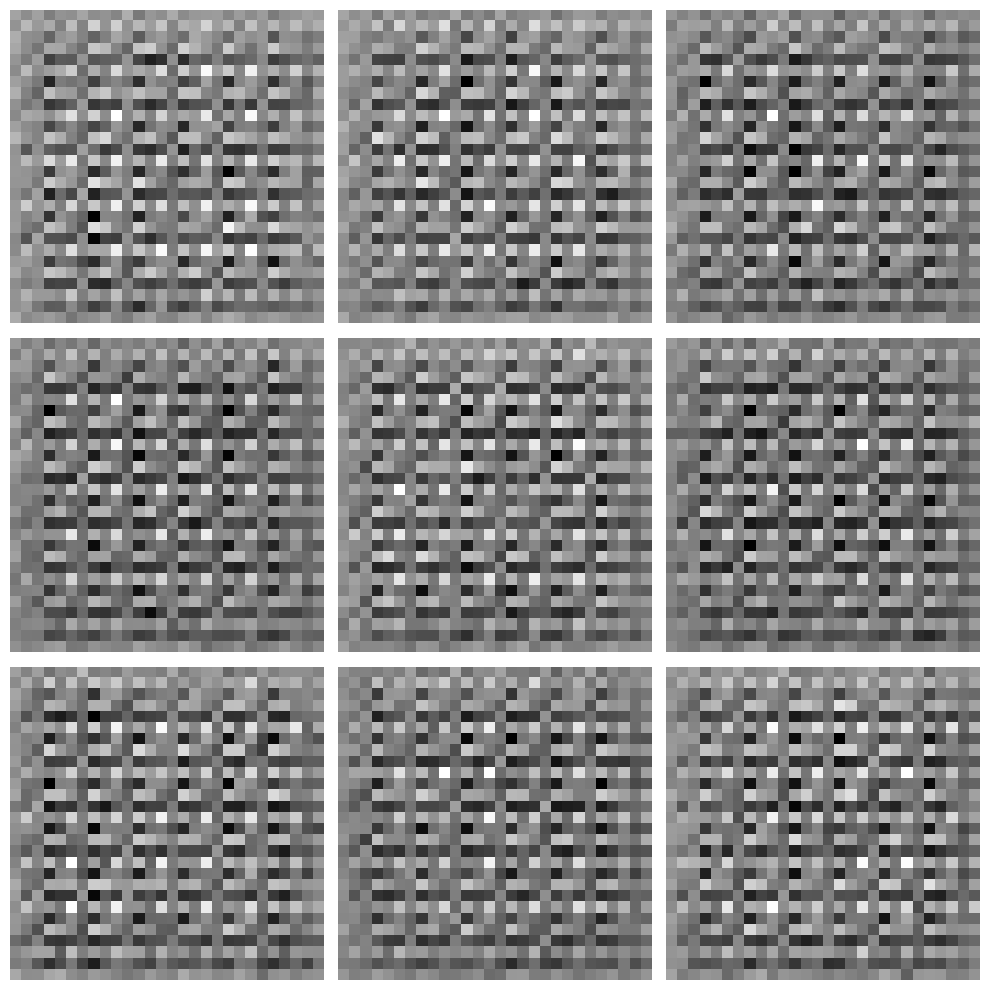

4/4 [==============================] - 1s 254ms/step
Epoch 2, Discriminator Loss: 0.6385173499584198, Generator Loss: 0.883486807346344
4/4 [==============================] - 1s 157ms/step
Epoch 3, Discriminator Loss: 0.5784226059913635, Generator Loss: 1.062530279159546
4/4 [==============================] - 1s 260ms/step
Epoch 4, Discriminator Loss: 0.5314206779003143, Generator Loss: 1.195380449295044
4/4 [==============================] - 1s 157ms/step
Epoch 5, Discriminator Loss: 0.5326941907405853, Generator Loss: 1.0259298086166382
4/4 [==============================] - 1s 159ms/step
Epoch 6, Discriminator Loss: 0.5809255987405777, Generator Loss: 0.7412233352661133
4/4 [==============================] - 1s 195ms/step
Epoch 7, Discriminator Loss: 0.5488134026527405, Generator Loss: 0.6712254285812378
4/4 [==============================] - 1s 159ms/step
Epoch 8, Discriminator Loss: 0.4749865159392357, Generator Loss: 0.6866863965988159
4/4 [==============================] - 1s 16

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam

# Define the dimensions of the input noise
noise_dim = 100

# Define the generator model
def build_generator():
    model = Sequential()
    model.add(Dense(7*7*128, input_dim=noise_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (7, 7), activation='sigmoid', padding='same'))
    return model

# Define the discriminator model
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

# Define the combined GAN model
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

# Compile the discriminator model
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])

# Compile the combined GAN model
generator = build_generator()
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
# Load the MNIST dataset
(X_train, _), (_, _) = mnist.load_data()

# Preprocess the data
X_train = X_train.astype('float32') / 255.0
X_train = np.expand_dims(X_train, axis=-1)

# Train the DCGAN
batch_size = 128
epochs = 10000

# Training loop
for epoch in range(epochs):
    # Select a random batch of real images
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_images = X_train[idx]

    # Generate a batch of fake images
    noise = np.random.normal(0, 1, (batch_size, noise_dim))
    fake_images = generator.predict(noise)

    # Train the discriminator
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))
    d_loss_real = discriminator.train_on_batch(real_images, real_labels)
    d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train the generator
    noise = np.random.normal(0, 1, (batch_size, noise_dim))
    g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

    # Print the progress
    print(f'Epoch {epoch+1}, Discriminator Loss: {d_loss[0]}, Generator Loss: {g_loss}')

    # Plot some generated images
    if epoch % 100 == 0:
        noise = np.random.normal(0, 1, (9, noise_dim))
        generated_images = generator.predict(noise)
        plt.figure(figsize=(10, 10))
        for i in range(9):
            plt.subplot(3, 3, i+1)
            plt.imshow(generated_images[i, :, :, 0], cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        plt.show()